# Eye movements Project

This notebook illustrates a data pipeline I created using python to create a combined dataset from a set of distributed participant files containing eye movements collected in a lab for neuroscience research. The structure of the pipeline is as follows:

1. Data cleaning and munging

2. Feature selection and engineering

3. Data exploration

4. Explore potential models and model selection

5. Test model assumptions, hyperparameter optimization and further feature engineering

6. Test model

7. Conclusion and insights

### More info:
The data utilised in this project is the result of combined experiment datasets that were collected over five separate experiments. In all of the experiments, participants were required to perform a prosaccade, antisaccade and optokinetic nystagmus (OKN) eye movement tasks before and after different drug interventions. The prosaccade and antisaccade task paradigms were kept the same across the experiments. For an in-depth description of task parameters and experimental protocols, see the methods section of the following papers:

- [Connell, CJW. et al (2017) Fatigue-related impairments in oculomotor control are prevented by norepinephrine-dopamine reuptake inhibition. *Scientific Reports* 7; 42726. doi: 10.1038/srep42726](https://www.nature.com/articles/srep42726?WT.feed_name=subjects_neuroscience)

- [Connell, CJW. et al (2017) Caffeine increases the velocity of rapid eye movements in unfatigued humans. *Psychopharmacology*; 234(15): 2311-2323. doi: 10.1007/s00213-017-4638-1](https://www.researchgate.net/publication/317187946_Caffeine_increases_the_velocity_of_rapid_eye_movements_in_unfatigued_humans)

- [Connell, CJW. et al (2017) Effects of dopamine and norepinephrine on exercise-induced oculomotor fatigue. *Medicine and Science in Sports & Exercise*; 49(9), 1778-1788. doi: 10.1249/MSS.0000000000001307](https://www.researchgate.net/publication/316570236_Effects_of_Dopamine_and_Norepinephrine_on_Exercise-induced_Oculomotor_Fatigue)

In [4]:
# import relevant packages

import pandas as pd
import tkinter as tk
from tkinter import filedialog
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from tkinter import filedialog
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
# set seaborn style
sns.set_style("dark")
sns.set_style("ticks")
%matplotlib inline

# 1. Data cleaning and munging

## Combining experimental datasets

The first step was to combine the prosaccade and antisaccade data from the participant excel files for all of the experiments. These files were distributed across a bunch of file directories, and each file contained several sheets (sometimes messy) that contained relevant data and experimental parameters that needed to be extracted and recombined into a single dataframe for each participant.

## Extract participant data (data types 1 & 2)

The code below was executed using spyder. I repeated execution for each participant file that had data I wanted to extract from it.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 22 02:15:30 2018
@author: Charlie
Code has been altered to allow for processing of data from both phd and honors expriments.
This program prompts user to select a participant saccade file, imports all 
the sheets and extracts experiment information, eye movement type, saccade 
measurement parameters and combines these into a summary participant data frame
which is exported into a common directory to later be processed by combineSaccadeFiles.py

"""


# obtain the filepath of the excel sheet to be imported

root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename()

# extract eye movement type, experiment name & subjectID and store in list

participant_details = []
        
def eye_movement(filename):
    """returns the type of eye movement that the excel file contains, based
    on the format of the file name"""
        
    if 'Prosaccade' in filename:
        participant_details.append('Prosaccade')
    elif 'Antisaccade' in filename:
        participant_details.append('Antisaccade')
    else:
        participant_details.append('saccade')

eye_movement(file_path)
filename = file_path.split('/')
filename = filename[-1]
filename = filename.replace('.xlsx', '')
filename_sep = filename.split('_')
participant_details.append(filename_sep[0])
participant_details.append('honors')
details_keys = ['saccade_type', 'subjectID', 'experiment']
participant_details = dict(zip(details_keys, participant_details))
subjectID = participant_details['subjectID']
saccade_type = participant_details['saccade_type'] 

# extract experiment data as dictionary of pandas dataframes

if 'crave' in participant_details['experiment']:
    experiment_data = pd.read_excel(file_path, sheetname=[participant_details['subjectID'] +'1a', participant_details['subjectID'] +'1b', participant_details['subjectID'] +'2a', participant_details['subjectID'] +'2b'], parse_cols='A:AB', na_values = {' inf', ' Inf', 'Inf', 'inf'})
elif 'honors' in participant_details['experiment']:
    experiment_data = pd.read_excel(file_path, sheetname=[0,1,3,4], parse_cols='A:Y', na_values = {' inf', ' Inf', 'Inf', 'inf'})
else:
    experiment_data = pd.read_excel(file_path, sheetname=[participant_details['subjectID'] +'1a', participant_details['subjectID'] +'1b', participant_details['subjectID'] +'2a', participant_details['subjectID'] +'2b', participant_details['subjectID'] +'3a', participant_details['subjectID'] +'3b'], parse_cols='A:AB', na_values = {' inf', ' Inf', 'Inf', 'inf'})

for key, value in experiment_data.items():
    if key == 0:
        value['trial'] = 1
        value['timepoint'] = 'a'
    elif key == 1:
        value['trial'] = 1
        value['timepoint'] = 'b'
    elif key == 3:
        value['trial'] = 2
        value['timepoint'] = 'a'
    elif key == 4:
        value['trial'] = 2
        value['timepoint'] = 'b'
    else:
        value['trial'] = 'error'
        value['timepoint'] = 'error'
    value['subjectID'] = subjectID
    value.columns = [
            'Eye',
            'trial_presentation_number',
            'condition',
            'gap_overlap',
            'direction',
            'stimulus_onset_delay',
            'valid',
            'baselinex80%',
            'baselinex150-50ms',
            'post_saccade_position',
            'start_time',
            'end_time',
            'duration',
            'start_position',
            'end_position',
            'distance',
            'speed',
            'overshoot',
            'correct_direction',
            'speed_no_sign',
            'velocity(deg_p_sec)',
            'units_moved_in_saccade',
            'deg_moved_in_saccade',
            'deg_off_target_no_sign',
            'trial',
            'timepoint',
            'subjectID'
            ]


experiment_data = pd.concat(experiment_data)

# remove saccades deemed invalid by human analyser

experiment_data = experiment_data[(experiment_data['valid'] == 1)]

# convert direction column to category

correct_direction = {1 : 'correct', 0: 'incorrect'}
experiment_data['correct_direction'] = experiment_data['correct_direction'].map(correct_direction)
del correct_direction

# set index of the experiment_data data frame

experiment_data['timepoint'] = experiment_data['timepoint'].astype('category')
#experiment_data['saccade_type'] = experiment_data['saccade_type'].astype('category')
experiment_data['direction'] = experiment_data['direction'].astype('category') 
experiment_data['gap_overlap'] = experiment_data['gap_overlap'].astype('category')
experiment_data = experiment_data.set_index('subjectID')
# export dataframe to csv file
export_path = 'C:/Users/ccon033/Dropbox/University/Charlotte/PhD-Experiments/Python-Projects/Saccades_data/honors/'
export_filename = subjectID + '_' + 'honors' + '.csv'
export = export_path + export_filename
experiment_data.to_csv(export)

## Combine individual datasets (data type 1)

In [ ]:
# prompt user to choose the directory containing participant saccades data

directory = filedialog.askdirectory()
os.chdir(directory)

# obtain the list of files in the directory

filelist = [f for f in listdir(directory) if isfile(join(directory, f))]

# combine all files into one massive dataframe

saccades_df = pd.concat([pd.read_csv(f, index_col=0, header=0) for f in filelist],
                         keys=filelist)

# export the combined dataframe to csv

export_path = filedialog.askdirectory()
export_filename = '/saccades_phd_data.csv'
export = export_path + export_filename
saccades_df.to_csv(export)

## Combine individual datasets (data type 2)

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 16 14:28:20 2017
@author: ccon033
Prompts user to select a directory containing .csv saccade files processed by
the importSaccadeFiles.py script. It collects all files in the directory, combines
them into a dataframe and exports to a .csv file.
"""
# prompt user to choose the directory containing participant saccades data

directory = filedialog.askdirectory()
os.chdir(directory)

# obtain the list of files in the directory

filelist = [f for f in listdir(directory) if isfile(join(directory, f))]

# combine all files into one massive dataframe

saccades_df = pd.concat([pd.read_csv(f, index_col=0, header=0) for f in filelist],
                         keys=filelist)

# export the combined dataframe to csv

export_path = filedialog.askdirectory()
export_filename = '/saccades_honors_data.csv'
export = export_path + export_filename
saccades_df.to_csv(export)

## Extract participant data (data type 3)

I had a pesky third dataset that was not in a format that was workable with the previous code. To extract the participant information from this I wrote a new set - it was easier and quicker than modifying the code above.

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 10 05:48:25 2018
prompts user to choose directory that contains all of shelleys participant
files. From the filename it derives the intervention, timepoint, and subject
information adds this to the dataframe and exports it to another directory
@author: Charlie Connell
"""

# prompt user to choose the directory containing participant saccades data

directory = filedialog.askdirectory()
os.chdir(directory)

# export path details
export_directory = 'C:/Users/ccon033/Dropbox/University/Charlotte/PhD-Experiments/Python-Projects/Saccades_data/shelley/'

# obtain the list of files in the directory

filelist = [f for f in listdir(directory) if isfile(join(directory, f))]

for file in filelist:
    
    file_info = str(file)
    
    # grab subject ID
    subject_ID = file_info[1]
    
    # get intervention information
    if 'CHO' in file_info:
        intervention = 'CHO'
    elif 'PLA' in file_info:
        intervention = 'PLA'
    else:
        print ('cant gather intervention information from' + file_info)
    
    # get timepoint information
    if 'Pre' in file_info:
        timepoint = 'pre'
    elif 'Post' in file_info:
        timepoint = 'post'
    else:
        print('cant gather timepoint information from' + file_info)
    
    # import data
    
    data = pd.read_excel(directory + '/' + file,
                         na_values={' inf', ' Inf', 'Inf', 'inf'})
    
    data['subject_id'] = subject_ID
    data['intervention'] = intervention
    data['timepoint'] = timepoint
    
    filename = subject_ID + '_' + intervention + '_' + timepoint + '_' + 'shelley.csv'
    data.to_csv(export_directory + filename)    

## Combine individual data (data type 3)

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 16 14:28:20 2017
@author: ccon033
Prompts user to select a directory containing .csv saccade files processed by
the importSaccadeFiles.py script. It collects all files in the directory, combines
them into a dataframe and exports to a .csv file.
"""
# prompt user to choose the directory containing participant saccades data

directory = filedialog.askdirectory()
os.chdir(directory)

# obtain the list of files in the directory

filelist = [f for f in listdir(directory) if isfile(join(directory, f))]

# combine all files into one massive dataframe

saccades_df = pd.concat([pd.read_csv(f, index_col=0, header=0) for f in filelist],
                         keys=filelist)

# export the combined dataframe to csv

export_path = filedialog.askdirectory()
export_filename = '/saccades_shelley_data.csv'
export = export_path + export_filename
saccades_df.to_csv(export)

Now we have three different summary data sheets containing saccades from three different experiments. It was easiest to clean and merge the participant characteristics into these data sheets seperately.

## Merge participant characteristics and clean data

## Clean and merge (data type 1):

In [15]:
# enter filepath of the csv file to be uploaded
file_path = '/Users/Charlie/Dropbox (Personal)/CV & Resume/Connell-CV/Applications_NYC_2017/Data Insights/March_2018/interview/Saccade_experiment_data/'
file_name = 'saccades_phd_data.csv'

# import file with saccades summary data
saccades_data = pd.read_csv(file_path + file_name)

# index the dataframe and remove useless columns
del saccades_data['Unnamed: 0']
del saccades_data['Unnamed: 1']

saccades_data_clean = saccades_data[['gap_overlap', 'direction', 'trial',
                                     'timepoint', 'Intervention', 'experiment',
                                     'saccade_type', 'collection_camera', 'status',
                                     'AverageSpeed(deg/s)', 'MaxSpeed(deg/s)',
                                     'Duration(ms)', 'Latency(ms)', 
                                     'saccade_initiation_type', 'Eye',
                                     'trial_presentation_number', 'subjectID',
                                     'deg_moved_in_saccade', 'correct_direction']]

# swap out participant codes

participant_array = list(saccades_data_clean.subjectID.unique())
participant_number = np.linspace(1, (len(participant_array)), num=(len(participant_array)))
code = dict(zip(participant_array, participant_number))

# export participant numbers/codes
pcodes = pd.DataFrame.from_dict(code, orient='index')
pcodes.to_csv(file_path + 'pcodes_phd.csv')

saccades_data_clean['participant_num'] = saccades_data_clean.loc[:,'subjectID'].map(code)
del saccades_data_clean['subjectID']
saccades_data_clean = saccades_data_clean.set_index('participant_num')

# unify experiment names (inconsistencies were from incorrectly named summary
# files)

def correct_experiment_names(y):
    if y == 'CRaVE':
        return 'crave'
    elif y == 'CRaVe':
        return 'crave'
    elif y == 'masterrave':
        return 'rave'
    else:
        return y

saccades_data_clean['Experiment'] = saccades_data_clean['experiment'].apply(correct_experiment_names)
del saccades_data_clean['experiment']

# correct information about fatigue status

def crave_status(z):
    if 'crave' in z['Experiment']:
        return 'unfatigued'
    elif 'crave' not in z['Experiment']:
        if z['timepoint']== 'a':
            return 'unfatigued'
        elif z['timepoint'] == 'b':
            return 'fatigued'


saccades_data_clean['status'] = saccades_data_clean.apply(crave_status, axis=1)

# export 'clean' version of the saccades data

export_filename = 'saccades_phd_clean.csv'
export = file_path + export_filename
saccades_data_clean.to_csv(export)

/Users/Charlie/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
saccades_data_clean.head()

,gap_overlap,direction,trial,timepoint,Intervention,saccade_type,collection_camera,status,AverageSpeed(deg/s),MaxSpeed(deg/s),Duration(ms),Latency(ms),saccade_initiation_type,Eye,trial_presentation_number,deg_moved_in_saccade,correct_direction,Experiment
participant_num,,,,,,,,,,,,,,,,,,
1.0,overlap,left,1,a,Caffeine,Antisaccade,A,unfatigued,231.864865,424.918919,42.0,465.0,normal,A,1.0,9.945946,1.0,crave
1.0,gap,left,1,a,Caffeine,Antisaccade,A,unfatigued,208.702703,537.837838,44.0,273.0,normal,A,2.0,9.027027,1.0,crave
1.0,gap,left,1,a,Caffeine,Antisaccade,A,unfatigued,198.918919,414.945946,40.0,286.0,normal,A,3.0,8.162162,1.0,crave
1.0,gap,right,1,a,Caffeine,Antisaccade,A,unfatigued,224.675676,548.486486,42.0,272.0,normal,A,4.0,8.918919,1.0,crave
1.0,gap,left,1,a,Caffeine,Antisaccade,A,unfatigued,222.081081,418.135135,34.0,190.0,normal,A,5.0,7.567568,1.0,crave


#### Pre-clean visualization

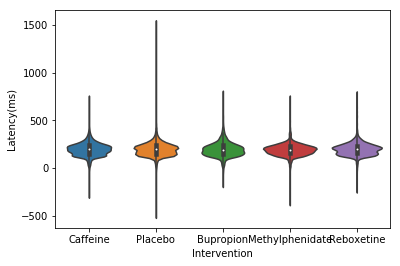

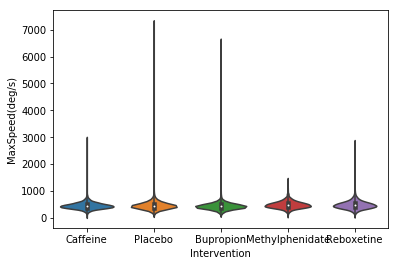

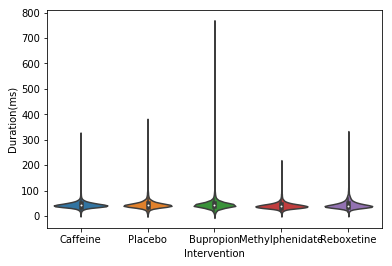

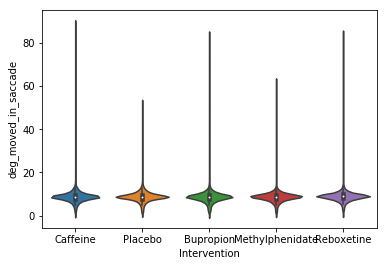

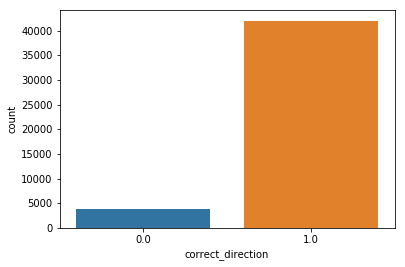

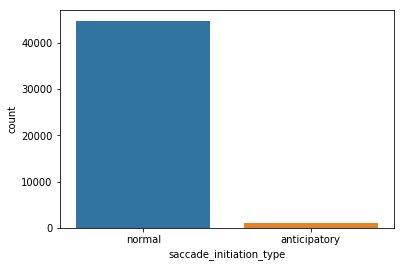

In [18]:
# data visualization pre cleaning

# variables
latency = saccades_data_clean['Latency(ms)']
velocity = saccades_data_clean['MaxSpeed(deg/s)']
duration = saccades_data_clean['Duration(ms)']
amplitude = saccades_data_clean['deg_moved_in_saccade']
correct_direction = saccades_data_clean['correct_direction']
intervention = saccades_data_clean['Intervention']
trial = saccades_data_clean['trial']
saccade_initiation = saccades_data_clean['saccade_initiation_type']

# violin plots of continuous variables

_ = sns.violinplot(intervention, latency)
plt.show()
_ = sns.violinplot(intervention, velocity)
plt.show()
_ = sns.violinplot(intervention, duration)
plt.show()
_ = sns.violinplot(intervention, amplitude)
plt.show()

# count plots for categorical variables

_ = sns.countplot(correct_direction)
plt.show()
_ = sns.countplot(saccade_initiation)
plt.show()

#### Data clean

In [19]:
# clean dataset further - remove outliers and impossible values. 
# cutoff numbers determined by what is physiologically possible
# outliers defined as those placed greater than 3 standard deviations away from the mean

saccades_final = saccades_data_clean[(saccades_data_clean['Duration(ms)']>0) & 
                                     (saccades_data_clean['Duration(ms)']< 600)
                                     & (saccades_data_clean['deg_moved_in_saccade']>1)
                                     & (saccades_data_clean['deg_moved_in_saccade']< 30)
                                     & (saccades_data_clean['AverageSpeed(deg/s)']>0)
                                     & (saccades_data_clean['AverageSpeed(deg/s)']< 1500)
                                     & (saccades_data_clean['MaxSpeed(deg/s)']>0)
                                     & (saccades_data_clean['MaxSpeed(deg/s)']< 2500)
                                     & (saccades_data_clean['Latency(ms)']<1000)]
saccades_final = saccades_final[np.abs(saccades_final['MaxSpeed(deg/s)']-saccades_final['MaxSpeed(deg/s)'].mean())<=(3*saccades_final['MaxSpeed(deg/s)'].std())]
saccades_final = saccades_final[np.abs(saccades_final['Duration(ms)']-saccades_final['Duration(ms)'].mean())<=(3*saccades_final['Duration(ms)'].std())]
saccades_final = saccades_final[np.abs(saccades_final['Latency(ms)']-saccades_final['Latency(ms)'].mean())<=(3*saccades_final['Latency(ms)'].std())]
saccades_final = saccades_final[np.abs(saccades_final['AverageSpeed(deg/s)']-saccades_final['AverageSpeed(deg/s)'].mean())<=(3*saccades_final['AverageSpeed(deg/s)'].std())]
saccades_final = saccades_final[np.abs(saccades_final['deg_moved_in_saccade']-saccades_final['deg_moved_in_saccade'].mean())<=(3*saccades_final['deg_moved_in_saccade'].std())]

#### Post-cleaning visualization

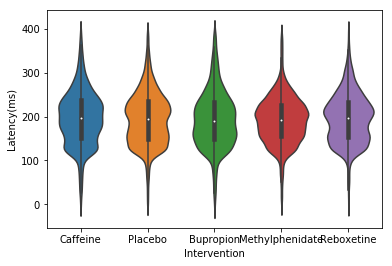

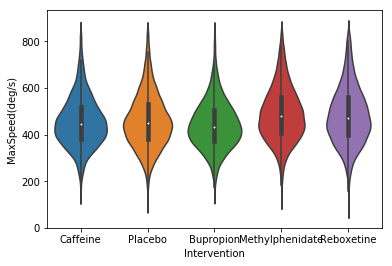

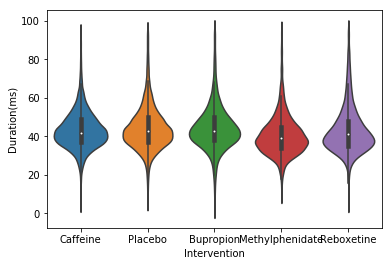

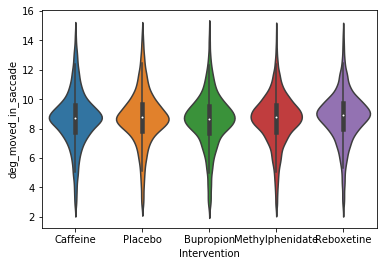

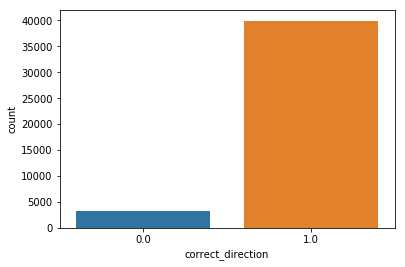

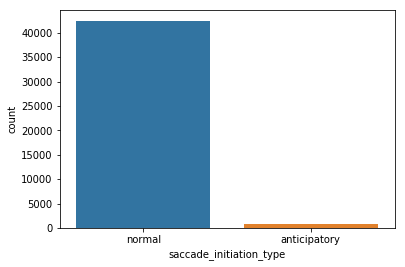

In [21]:
# data visualization post cleaning

# variables
latency = saccades_final['Latency(ms)']
velocity = saccades_final['MaxSpeed(deg/s)']
duration = saccades_final['Duration(ms)']
amplitude = saccades_final['deg_moved_in_saccade']
correct_direction = saccades_final['correct_direction']
intervention = saccades_final['Intervention']
trial = saccades_final['trial']
saccade_initiation = saccades_final['saccade_initiation_type']

# violin plots of continuous variables

_ = sns.violinplot(intervention, latency)
plt.show()
_ = sns.violinplot(intervention, velocity)
plt.show()
_ = sns.violinplot(intervention, duration)
plt.show()
_ = sns.violinplot(intervention, amplitude)
plt.show()

# count plots for categorical variables

_ = sns.countplot(correct_direction)
plt.show()
_ = sns.countplot(saccade_initiation)
plt.show()

#### Post-cleaning export

In [22]:
# export 'final' version of the saccades data

export_filename = 'saccades_phd_final.csv'
export = file_path + export_filename
saccades_final.to_csv(export)

## Clean and merge (data type 2):

In [7]:
# import files into dataframes
filepath = '/Users/Charlie/Dropbox (Personal)/CV & Resume/Connell-CV/Applications_NYC_2017/Data Insights/March_2018/interview/Saccade_experiment_data/'
saccades_file = 'saccades_honors_data.csv'
participant_file = 'pcharacteristics_honors.xlsx'
saccades_data = pd.read_csv(filepath + saccades_file)
characteristics_data = pd.read_excel(filepath + participant_file)


# functions
def status(q):
    """adds in information about fatigue status"""
    if q['timepoint']== 'a':
        return 'unfatigued'
    elif q['timepoint'] == 'b':
        return 'fatigued'

def saccade_initiation(r):
    """categorizes saccade latencies as anticipatory or normal"""
    if r['latency(ms)'] < 70:
        return 'anticipatory'
    elif r['latency(ms)'] > 70:
        return 'normal'
    
def convert_to_milliseconds(y):
    """converts from seconds to milliseconds"""
    return y*1000

def convert_str2num(z, position=-1):
    """converts string to a number given the series and 
    position of the string. Number Position has to be the 
    same for the entire column"""
    int(z[[position]])

# add fatigue status
saccades_data['status'] = saccades_data.apply(status, axis=1)

# calculate latency 
saccades_data['latency(s)'] = (saccades_data['start_time'] - 
              saccades_data['stimulus_onset_delay'])

# convert duration(s) to duration(ms)
saccades_data['duration(ms)'] = saccades_data[['duration']].apply(
        convert_to_milliseconds)

#convert latency(s) to latency(ms)
saccades_data['latency(ms)'] = saccades_data[['latency(s)']].apply(
        convert_to_milliseconds)

# categorize saccades
saccades_data['saccade_initiation_type'] = saccades_data[['latency(ms)']].apply(
        saccade_initiation, axis=1)

# get participant characteristics data ready to merge with saccades
intervention_info = characteristics_data[['Participant', 'Trial 1', 'Trial 2']]
intervention_info = pd.melt(intervention_info, id_vars='Participant', 
                            var_name='Trial_number', value_name='Intervention')
characteristics_data = characteristics_data.drop(
        ['Trial 1', 'Trial 2'], axis=1)
characteristics_data = characteristics_data.merge(intervention_info, 
                                                  how='inner',
                                                  left_on=['Participant'],
                                                  right_on=['Participant'])

# convert trial information from string to numbers
characteristics_data['Trial'] = characteristics_data.Trial_number.str.extract(
        '(\d+)', expand=False)

del characteristics_data['Trial_number']

characteristics_data.Trial = pd.to_numeric(characteristics_data.Trial, 
                                           errors='coerce')

# merge the datasets
saccades_full = saccades_data.merge(characteristics_data, how='inner', 
                                    left_on =['subjectID', 'trial'], 
                                    right_on =['Participant', 'Trial'])
saccades_full['experiment'] = 'honors'

# export pre-cleaned version of saccades df to csv
export_path = '/Users/Charlie/Dropbox (Personal)/CV & Resume/Connell-CV/Applications_NYC_2017/Data Insights/March_2018/interview/Saccade_experiment_data/'
export_filename = 'saccades_honors_clean.csv'
export = export_path + export_filename
saccades_full.to_csv(export)

# index the dataframe and remove useless columns
del saccades_full['Unnamed: 0']

saccades_data_clean = saccades_full[['gap_overlap', 'direction', 'Trial',
                                     'timepoint', 'Intervention', 'experiment',
                                     'saccade_initiation_type', 'valid', 
                                     'Eye', 'status', 'correct_direction',
                                     'velocity(deg_p_sec)',
                                     'duration(ms)', 'latency(ms)',
                                     'trial_presentation_number', 'Participant',
                                     'deg_moved_in_saccade', 'Gender', 'Age',
                                     'Weight(kg)', 'Height(cm)', 
                                     'VO2max(mL/kg/min)', 'Wattage at 60% VO2max']]

# swap out participant names for numbered codes

participant_array = list(saccades_data_clean.Participant.unique())
participant_number = list(range(38, (len(participant_array) + 38)))
code = dict(zip(participant_array, participant_number))

# export participant numbers/codes
pcodes = pd.DataFrame.from_dict(code, orient='index')
pcodes.to_csv(export_path + 'pcodes_honors.csv')

participant_map = saccades_data_clean.loc[:,'Participant'].map(code)
saccades_data_clean['participant_num'] = participant_map

/Users/Charlie/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Pre-cleaning visualization

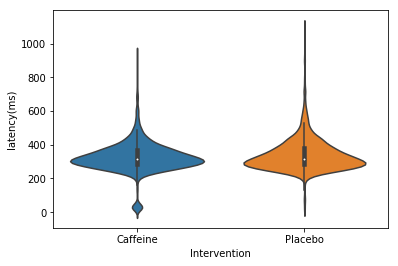

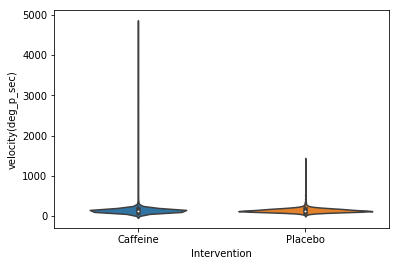

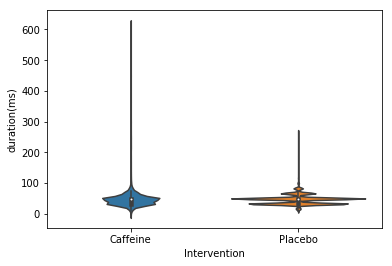

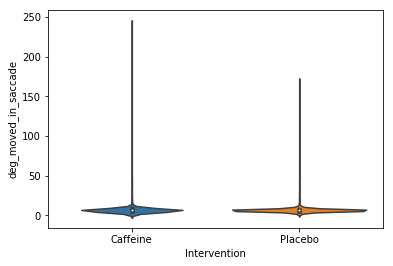

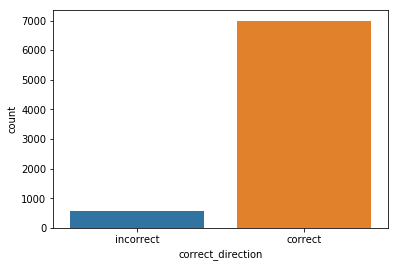

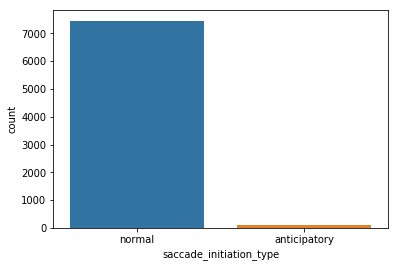

In [8]:
# data visualization pre cleaning

# variables
latency = saccades_full['latency(ms)']
velocity = saccades_full['velocity(deg_p_sec)']
duration = saccades_full['duration(ms)']
amplitude = saccades_full['deg_moved_in_saccade']
correct_direction = saccades_full['correct_direction']
intervention = saccades_full['Intervention']
trial = saccades_full['trial']
saccade_initiation = saccades_full['saccade_initiation_type']

# violin plots of continuous variables

_ = sns.violinplot(intervention, latency)
plt.show()
_ = sns.violinplot(intervention, velocity)
plt.show()
_ = sns.violinplot(intervention, duration)
plt.show()
_ = sns.violinplot(intervention, amplitude)
plt.show()

# count plots for categorical variables

_ = sns.countplot(correct_direction)
plt.show()
_ = sns.countplot(saccade_initiation)
plt.show()

#### Clean + post-clean visualization

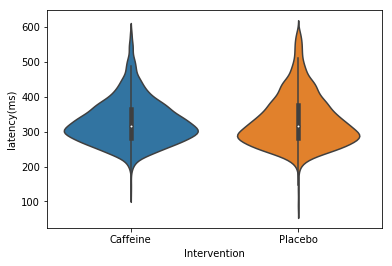

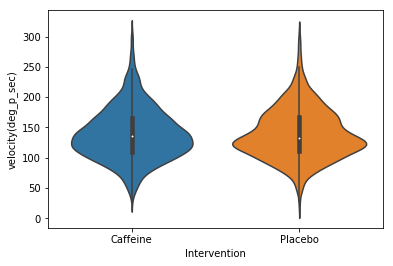

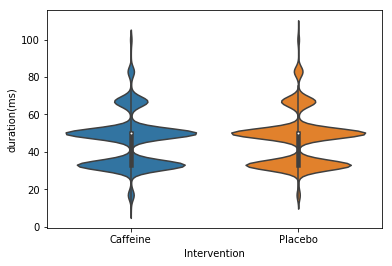

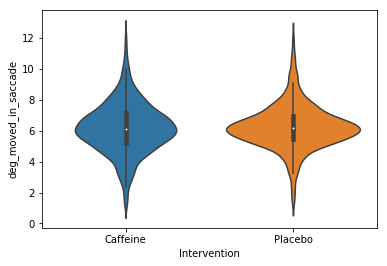

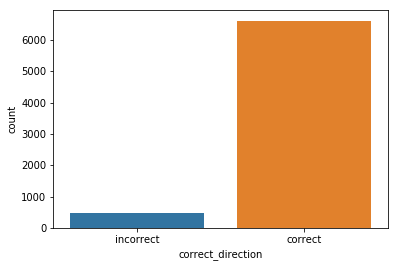

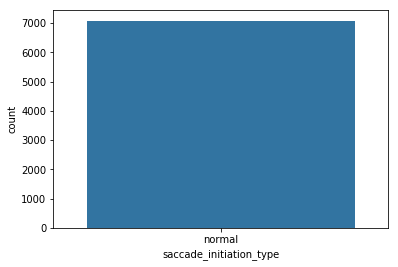

In [9]:
# clean dataset further - remove outliers and impossible values. 
# cutoff numbers determined by what is physiologically possible
# outliers defined as those placed greater than 3 standard deviations away from the mean

saccades_final = saccades_data_clean[(saccades_data_clean['duration(ms)']>0) & 
                                     (saccades_data_clean['duration(ms)']<600)
                                     & (saccades_data_clean['deg_moved_in_saccade']>1)
                                     & (saccades_data_clean['deg_moved_in_saccade']< 30)
                                     & (saccades_data_clean['velocity(deg_p_sec)']>0)
                                     & (saccades_data_clean['velocity(deg_p_sec)']< 1500)
                                     & (saccades_data_clean['latency(ms)']<1000)]

saccades_final = saccades_final[np.abs(saccades_final['duration(ms)']-saccades_final['duration(ms)'].mean())<=(3*saccades_final['duration(ms)'].std())]
saccades_final = saccades_final[np.abs(saccades_final['latency(ms)']-saccades_final['latency(ms)'].mean())<=(3*saccades_final['latency(ms)'].std())]
saccades_final = saccades_final[np.abs(saccades_final['velocity(deg_p_sec)']-saccades_final['velocity(deg_p_sec)'].mean())<=(3*saccades_final['velocity(deg_p_sec)'].std())]
saccades_final = saccades_final[np.abs(saccades_final['deg_moved_in_saccade']-saccades_final['deg_moved_in_saccade'].mean())<=(3*saccades_final['deg_moved_in_saccade'].std())]

# data visualization post cleaning

# variables
latency = saccades_final['latency(ms)']
velocity = saccades_final['velocity(deg_p_sec)']
duration = saccades_final['duration(ms)']
amplitude = saccades_final['deg_moved_in_saccade']
correct_direction = saccades_final['correct_direction']
intervention = saccades_final['Intervention']
trial = saccades_final['Trial']
saccade_initiation = saccades_final['saccade_initiation_type']

# violin plots of continuous variables

_ = sns.violinplot(intervention, latency)
plt.show()
_ = sns.violinplot(intervention, velocity)
plt.show()
_ = sns.violinplot(intervention, duration)
plt.show()
_ = sns.violinplot(intervention, amplitude)
plt.show()

# count plots for categorical variables

_ = sns.countplot(correct_direction)
plt.show()
_ = sns.countplot(saccade_initiation)
plt.show()

### Export dataset

In [10]:
# add in columns
saccades_final['saccade_type'] = 'saccade'
saccades_final['MaxSpeed(deg/s)'] = saccades_final['velocity(deg_p_sec)']
saccades_final['collection_camera'] = saccades_final['Eye']

# rename columns
column_names = {'Trial': 'trial', 'velocity(deg_p_sec)': 'AverageSpeed(deg/s)',
                'duration(ms)':'Duration(ms)', 'latency(ms)':'Latency(ms)',
                'experiment':'Experiment'}

saccades_final.rename(index=str, columns=column_names)

export_filename = 'saccades_honors_final.csv'
export = export_path + export_filename
saccades_final.to_csv(export)

## Clean and merge (data type 3)

In [11]:
# import files into dataframes

filepath = '/Users/Charlie/Dropbox (Personal)/CV & Resume/Connell-CV/Applications_NYC_2017/Data Insights/March_2018/interview/Saccade_experiment_data/'
saccades_file = 'saccades_shelley_data.csv'
participant_file = 'pcharacteristics_shelley.xlsx'
saccades_data = pd.read_csv(filepath + saccades_file)
# remove spaces from column names
saccades_data.columns = saccades_data.columns.str.replace('\s+', '')
# replace timepoint pre/post with a/b
timepoint_map = {'pre':'a', 'post':'b'}
saccades_data['timepoint'] = saccades_data['timepoint'].map(timepoint_map)
# include only 'valid' saccades
saccades_data = saccades_data[saccades_data['valid']==1]

del timepoint_map

characteristics_data = pd.read_excel(filepath + participant_file)

# functions

def status(q):
    """adds in information about fatigue status"""
    if q['timepoint']== 'a':
        return 'unfatigued'
    elif q['timepoint'] == 'b':
        return 'fatigued'

def saccade_initiation(r):
    """categorizes saccade latencies as anticipatory or normal"""
    if r['latency(ms)'] < 70:
        return 'anticipatory'
    elif r['latency(ms)'] > 70:
        return 'normal'
    
def convert_to_milliseconds(y):
    """converts from seconds to milliseconds"""
    return y*1000

def convert_str2num(z, position=-1):
    """converts string to a number given the series and 
    position of the string. Number Position has to be the 
    same for the entire column"""
    int(z[[position]])

# add fatigue status
saccades_data['status'] = saccades_data.apply(status, axis=1)

# calculate latency 
saccades_data['latency(s)'] = (saccades_data['start_time'] - 
              saccades_data['stimulusonsetdelayeye'])

# convert duration(s) to duration(ms)
saccades_data['duration(ms)'] = saccades_data[['duration']].apply(
        convert_to_milliseconds)

#convert latency(s) to latency(ms)
saccades_data['latency(ms)'] = saccades_data[['latency(s)']].apply(
        convert_to_milliseconds)

# categorize saccade initiation type
saccades_data['saccade_initiation_type'] = saccades_data[['latency(ms)']].apply(
        saccade_initiation, axis=1)

# create column for speed in deg_p_sec (conversion from eye tracker units)
saccades_data['velocity(deg_p_sec)'] = saccades_data['speednosign']/0.037

# merge the datasets
saccades_full = saccades_data.merge(characteristics_data, how='inner', 
                                    left_on =['subject_id', 'intervention'], 
                                    right_on =['Participant', 'Intervention'])
saccades_full['experiment'] = 'shelley'
saccades_full['saccade_type'] = 'saccade'

# remove useless columns and rename columns

del saccades_full['Unnamed:0']
del saccades_full['Unnamed:1']
del saccades_full['Participant']

# export pre-cleaned version of saccades df to csv
export_path = '/Users/Charlie/Dropbox (Personal)/CV & Resume/Connell-CV/Applications_NYC_2017/Data Insights/March_2018/interview/Saccade_experiment_data/'
export_filename = 'saccades_shelley_clean.csv'
export = export_path + export_filename
saccades_full.to_csv(export)

#### Pre-clean visualization

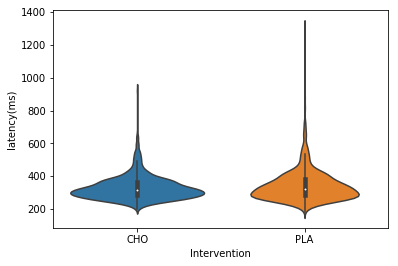

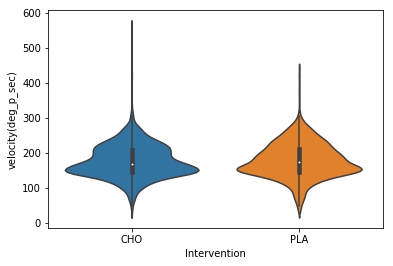

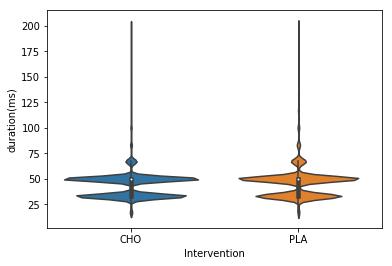

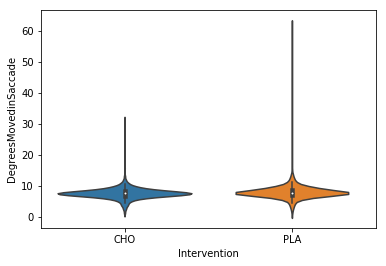

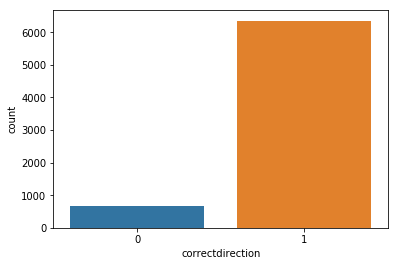

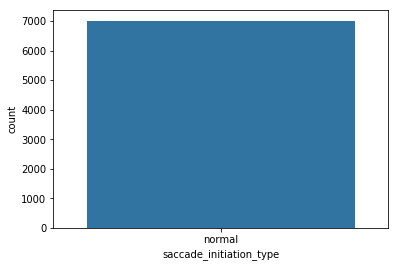

In [12]:
# data visualization pre cleaning

# variables
latency = saccades_full['latency(ms)']
velocity = saccades_full['velocity(deg_p_sec)']
duration = saccades_full['duration(ms)']
amplitude = saccades_full['DegreesMovedinSaccade']
correct_direction = saccades_full['correctdirection']
intervention = saccades_full['Intervention']
trial = saccades_full['Trial']
saccade_initiation = saccades_full['saccade_initiation_type']

# violin plots of continuous variables

_ = sns.violinplot(intervention, latency)
plt.show()
_ = sns.violinplot(intervention, velocity)
plt.show()
_ = sns.violinplot(intervention, duration)
plt.show()
_ = sns.violinplot(intervention, amplitude)
plt.show()

# count plots for categorical variables

_ = sns.countplot(correct_direction)
plt.show()
_ = sns.countplot(saccade_initiation)
plt.show()

#### Clean dataset

In [13]:
# rename columns
column_names = {'congruency':'gap_overlap', 'correctdirection': 'correct_direction',
                'trialnumber':'trial_presentation_number', 'subject_id': 'Participant',
                'DegreesMovedinSaccade':'deg_moved_in_saccade',
                'experiment':'Experiment'}

saccades_full = saccades_full.rename(index=str, columns=column_names)

saccades_data_clean = saccades_full[['gap_overlap', 'direction', 'Trial',
                                     'timepoint', 'Intervention',
                                     'saccade_initiation_type', 'valid', 
                                     'Eye', 'status', 'correct_direction',
                                     'velocity(deg_p_sec)',
                                     'duration(ms)', 'latency(ms)',
                                     'trial_presentation_number', 'Participant',
                                     'deg_moved_in_saccade', 'Gender', 'Age',
                                     'Weight(kg)', 'Height(cm)', 
                                     'VO2max(mL/kg/min)', 'Experiment',
                                     'saccade_type', 'Watts']]

# swap out participant names for numbered codes

participant_array = list(saccades_data_clean.Participant.unique())
participant_number = list(range(49, (len(participant_array) + 49)))
code = dict(zip(participant_array, participant_number))

# export participant numbers/codes
pcodes = pd.DataFrame.from_dict(code, orient='index')
pcodes.to_csv(export_path + 'pcodes_shelley.csv')

participant_map = saccades_data_clean.loc[:,'Participant'].map(code)
saccades_data_clean['participant_num'] = participant_map

# clean dataset further - remove outliers and impossible values. 
# cutoff numbers determined by what is physiologically possible
# outliers defined as those placed greater than 3 standard deviations away from the mean

saccades_final = saccades_data_clean[(saccades_data_clean['duration(ms)']>0) & 
                                     (saccades_data_clean['duration(ms)']<600)
                                     & (saccades_data_clean['deg_moved_in_saccade']>1)
                                     & (saccades_data_clean['deg_moved_in_saccade']< 30)
                                     & (saccades_data_clean['velocity(deg_p_sec)']>0)
                                     & (saccades_data_clean['velocity(deg_p_sec)']< 1500)
                                     & (saccades_data_clean['latency(ms)']<1000)]

saccades_final = saccades_final[np.abs(saccades_final['duration(ms)']-saccades_final['duration(ms)'].mean())<=(3*saccades_final['duration(ms)'].std())]
saccades_final = saccades_final[np.abs(saccades_final['latency(ms)']-saccades_final['latency(ms)'].mean())<=(3*saccades_final['latency(ms)'].std())]
saccades_final = saccades_final[np.abs(saccades_final['velocity(deg_p_sec)']-saccades_final['velocity(deg_p_sec)'].mean())<=(3*saccades_final['velocity(deg_p_sec)'].std())]
saccades_final = saccades_final[np.abs(saccades_final['deg_moved_in_saccade']-saccades_final['deg_moved_in_saccade'].mean())<=(3*saccades_final['deg_moved_in_saccade'].std())]

/Users/Charlie/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Post-clean visualization

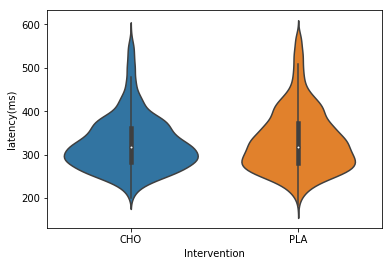

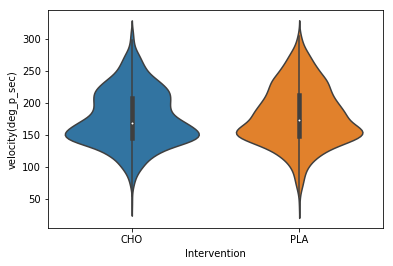

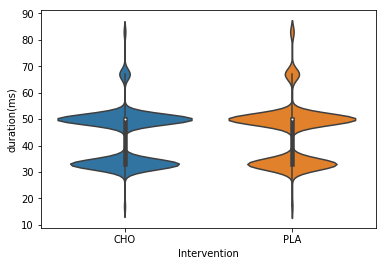

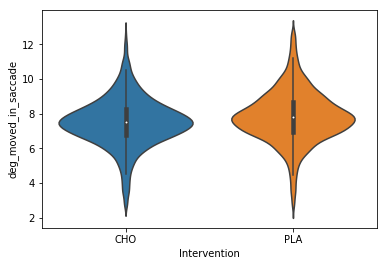

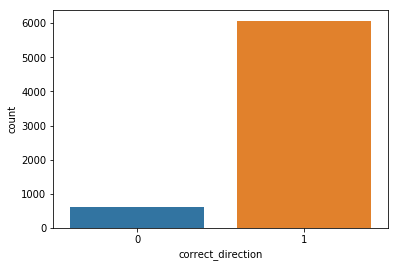

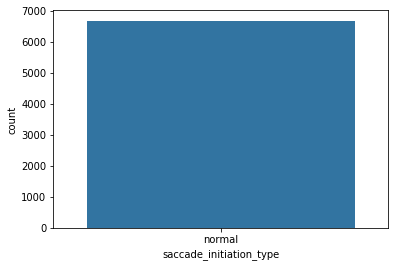

In [14]:
# data visualization post cleaning

# variables
latency = saccades_final['latency(ms)']
velocity = saccades_final['velocity(deg_p_sec)']
duration = saccades_final['duration(ms)']
amplitude = saccades_final['deg_moved_in_saccade']
correct_direction = saccades_final['correct_direction']
intervention = saccades_final['Intervention']
trial = saccades_final['Trial']
saccade_initiation = saccades_final['saccade_initiation_type']

# violin plots of continuous variables

_ = sns.violinplot(intervention, latency)
plt.show()
_ = sns.violinplot(intervention, velocity)
plt.show()
_ = sns.violinplot(intervention, duration)
plt.show()
_ = sns.violinplot(intervention, amplitude)
plt.show()

# count plots for categorical variables

_ = sns.countplot(correct_direction)
plt.show()
_ = sns.countplot(saccade_initiation)
plt.show()

# add in columns
saccades_final['MaxSpeed(deg/s)'] = saccades_final['velocity(deg_p_sec)']
saccades_final['collection_camera'] = saccades_final['Eye']

# rename columns
column_names = {'Trial': 'trial', 'velocity(deg_p_sec)': 'AverageSpeed(deg/s)',
                'duration(ms)':'Duration(ms)', 'latency(ms)':'Latency(ms)'}

saccades_final.rename(index=str, columns=column_names)

export_filename = 'saccades_shelley_final.csv'
export = export_path + export_filename
saccades_final.to_csv(export)

## Combine experimental datasets
The second step was simply to combine the clean data from all three experiments into one dataframe

In [66]:
# import data files
directory    = '/Users/Charlie/Dropbox (Personal)/CV & Resume/Connell-CV/Applications_NYC_2017/Data Insights/March_2018/interview/Saccade_experiment_data/'
phd_file     = 'saccades_phd_final.csv'
honors_file  = 'saccades_honors_final.csv'
shelley_file = 'saccades_shelley_final.csv'

phd_saccades    = pd.read_csv(directory + phd_file)
honors_saccades = pd.read_csv(directory + honors_file)
shelley_saccades = pd.read_csv(directory + shelley_file)

# rename certain columns
phd_columns = {'AverageSpeed(deg/s)':'velocity(deg_p_sec)',
               'Duration(ms)': 'duration(ms)',
               'Latency(ms)': 'latency(ms)'}
honors_columns = {'experiment': 'Experiment'}

phd_saccades = phd_saccades.rename(index=str, columns=phd_columns)
honors_saccades = honors_saccades.rename(index=str, columns=honors_columns)

# map correct directions
saccade_direction = {'correct': 1, 'incorrect': 0}
honors_saccades['correct_direction'] = honors_saccades['correct_direction'].map(
        saccade_direction)

# map common intervention names
intervention_names = {'PLA': 'placebo', 'CHO': 'carbohydrate'}
shelley_saccades['Intervention'] = shelley_saccades['Intervention'].map(
        intervention_names)

# create characteristics df for all experiments
phd_characteristics = pd.read_csv(directory + 'pcharacteristics_phd.csv')
honors_characteristics = pd.read_csv(directory + 'pcharacteristics_honors.csv')
honors_pcodes = pd.read_csv(directory + 'pcodes_honors.csv')
shelley_characteristics = pd.read_csv(directory + 'pcharacteristics_shelley.csv')
shelley_pcodes = pd.read_csv(directory + 'pcodes_shelley.csv')

# characteristics df with pcodes for honors
honors_characteristics = honors_characteristics.merge(honors_pcodes,
                                                      how='inner',
                                                      left_on=['participant_num'],
                                                      right_on=['Unnamed: 0'])
del honors_characteristics['participant_num']
del honors_characteristics['Unnamed: 0']
honors_characteristics = honors_characteristics.rename(
        index=str, columns={'0': 'participant_num'})

#characteristics df with pcodes for shelley
shelley_characteristics = shelley_characteristics.merge(shelley_pcodes,
                                                        how='inner',
                                                        left_on=['Participant'],
                                                        right_on=['Unnamed: 0'])



shelley_characteristics = shelley_characteristics.rename(
        index=str, columns={'0': 'participant_num', 
                            'Gender':'Sex'})
shelley_characteristics['Height(m)'] = shelley_characteristics['Height(cm)']/100
del shelley_characteristics['Height(cm)']
del shelley_characteristics['Participant']
del shelley_characteristics['Unnamed: 0']

# rename some columns in the phd characteristics set
phd_characteristics = phd_characteristics.rename(
        index=str, columns={'Height (m)': 'Height(m)',
                            'Weight (kg)': 'Weight(kg)'})

# concatenate common columns from the three dataframes
data_frames = [phd_saccades, honors_saccades, shelley_saccades]
common_data = list(set.intersection(*(set(df.columns) for df in data_frames)))
saccades = pd.concat(
        [df[common_data] for df in data_frames], ignore_index=True)

# do the same for the characteristics frames
characteristics_frames = [phd_characteristics, honors_characteristics,
                          shelley_characteristics]
common_characteristics = list(set.intersection(*(set(df.columns) for df in
                                                 characteristics_frames)))
characteristics = pd.concat(
        [df[common_characteristics] for df in characteristics_frames],
        ignore_index=True)

Lets check out the dataset and check that everything looks ok:

In [67]:
saccades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56942 entries, 0 to 56941
Data columns (total 18 columns):
timepoint                    56942 non-null object
gap_overlap                  56942 non-null object
latency(ms)                  56942 non-null float64
correct_direction            56942 non-null float64
velocity(deg_p_sec)          56942 non-null float64
Eye                          56942 non-null object
saccade_initiation_type      56942 non-null object
trial_presentation_number    56942 non-null float64
duration(ms)                 56942 non-null float64
deg_moved_in_saccade         56942 non-null float64
status                       56942 non-null object
participant_num              56942 non-null float64
direction                    56942 non-null object
saccade_type                 56942 non-null object
collection_camera            56942 non-null object
MaxSpeed(deg/s)              56942 non-null float64
Intervention                 56942 non-null object
Experiment      

In [68]:
# check that there isn't anything unexpected in the categorical variables in the dataset
print(pd.unique(saccades[['gap_overlap']].values.ravel()))
print(pd.unique(saccades[['direction']].values.ravel()))
print(pd.unique(saccades[['timepoint']].values.ravel()))
print(pd.unique(saccades[['Intervention']].values.ravel()))
print(pd.unique(saccades[['Experiment']].values.ravel()))
print(pd.unique(saccades[['saccade_type']].values.ravel()))
print(pd.unique(saccades[['collection_camera']].values.ravel()))
print(pd.unique(saccades[['status']].values.ravel()))
print(pd.unique(saccades[['saccade_initiation_type']].values.ravel()))

[' gap' ' overlap' ' inc' ' con']
[' left' ' right']
['a' 'b']
['Caffeine' 'Placebo' 'Bupropion' 'Methylphenidate' 'Reboxetine'
 'carbohydrate' 'placebo']
['crave' 'feeble' 'rave' 'honors' 'shelley']
['Antisaccade' 'Prosaccade' 'saccade']
['A' 'B' 'Both']
['unfatigued' 'fatigued']
['normal' 'anticipatory']


We need to correct the overlap in Intervention names. The lower case 'carbohydrate' intervention is actually the same as the 'Placebo' intervention (the participants in both cases received the same amount of carbohydrate throughout exercise at regular intervals). While in the lower case 'placebo', participants exercised and received a drink containing no carbohydrate. There is more information on interventions in the papers cited at the top of the notebook.

In [70]:
# correct intervention labels

def correct_intervention_labels(y):
    if y == 'Placebo':
        return 'Carbohydrate'
    elif y == 'carbohydrate':
        return 'Carbohydrate'
    elif y != 'Placebo' or y != 'Carbohydrate' or y != 'carbohydrate':
        return y
    
saccades['intervention'] = saccades['Intervention'].apply(correct_intervention_labels)
del saccades['Intervention']
print(pd.unique(saccades[['intervention']].values.ravel()))

# export a copy of these combined data
saccades.to_csv(directory + 'saccades_combined.csv')
characteristics.to_csv(directory + 'pcharacteristics_combined.csv')

['Caffeine' 'Carbohydrate' 'Bupropion' 'Methylphenidate' 'Reboxetine'
 'placebo']


# 2. Feature selection and engineering

## Using bootstrap analysis to create a binary indicator of 'exercise-induced oculomotor fatigue'

One of the major findings of this work was that when a person exercises for three hours, their eye movement velocity slows down, without any changes to the amplitude of the eye movement. We think that this is indicative of the development of a brain fatigue due to the prolonged exercise. In support of this hypothesis, we found that drugs that are known to act as central nervous system stimulants, e.g. caffeine, appear to prevent eye movements from slowing i.e. they prevent brain fatigue during exercise. I wanted to see if it was possible to use machine learning to predict whether a persons would experience brain fatigue after exercise given information about the intervention they received, the physical work they performed and their physical characteristics such as physical fitness, biological sex, age, the amount of physical work they performed across a time period etc.

To do this though, I first needed to create a binary indicator of whether each participant actually displayed a meaningful reduction in their eye movement velocity across time. To do this I decided to use a bootstrap analysis to create 90% CI of the mean eye movement velocity. Then, by comparing whether the upper bound of the 'post' timepoint was lower than the lower bound of the 'pre' timepoint, I could categorize that participant as displaying eye movement fatigue or not.

In [71]:
# set pandas to show all columns in data frame
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' %x)

# set directory and file names
directory = '/Users/Charlie/Dropbox (Personal)/CV & Resume/Connell-CV/Applications_NYC_2017/Data Insights/March_2018/interview/Saccade_experiment_data/'
characteristics = 'pcharacteristics_combined.csv'
saccades = 'saccades_combined.csv'

# import and merge files
characteristics_df = pd.read_csv(directory + characteristics, 
                                 index_col='participant_num')
saccades_df = pd.read_csv(directory + saccades, 
                          index_col='participant_num')

del characteristics_df['Unnamed: 0']
del saccades_df['Unnamed: 0']

# join datasets and reset the index so participant_num is its own column
data = saccades_df.join(characteristics_df)
data = data.reset_index()

data.head(10)

,participant_num,timepoint,gap_overlap,latency(ms),correct_direction,velocity(deg_p_sec),Eye,saccade_initiation_type,trial_presentation_number,duration(ms),deg_moved_in_saccade,status,direction,saccade_type,collection_camera,MaxSpeed(deg/s),Experiment,intervention,Age,Sex,Weight(kg),Watts,VO2max(ml/kg/min),Height(m)
0,1.00,a,gap,273.00,1.00,208.70,A,normal,2.00,44.00,9.03,unfatigued,left,Antisaccade,A,537.84,crave,Caffeine,25,Female,59.40,0,42.00,1.68
1,1.00,a,gap,286.00,1.00,198.92,A,normal,3.00,40.00,8.16,unfatigued,left,Antisaccade,A,414.95,crave,Caffeine,25,Female,59.40,0,42.00,1.68
2,1.00,a,gap,272.00,1.00,224.68,A,normal,4.00,42.00,8.92,unfatigued,right,Antisaccade,A,548.49,crave,Caffeine,25,Female,59.40,0,42.00,1.68
3,1.00,a,gap,190.00,1.00,222.08,A,normal,5.00,34.00,7.57,unfatigued,left,Antisaccade,A,418.14,crave,Caffeine,25,Female,59.40,0,42.00,1.68
4,1.00,a,overlap,351.00,1.00,180.76,A,normal,6.00,52.00,9.38,unfatigued,left,Antisaccade,A,601.81,crave,Caffeine,25,Female,59.40,0,42.00,1.68
5,1.00,a,overlap,243.00,1.00,215.43,A,normal,7.00,42.00,8.81,unfatigued,left,Antisaccade,A,472.97,crave,Caffeine,25,Female,59.40,0,42.00,1.68
6,1.00,a,gap,235.00,1.00,199.30,A,normal,8.00,47.00,9.27,unfatigued,left,Antisaccade,A,788.86,crave,Caffeine,25,Female,59.40,0,42.00,1.68
7,1.00,a,gap,182.00,0.00,250.30,A,normal,9.00,35.00,8.68,unfatigued,right,Antisaccade,A,427.92,crave,Caffeine,25,Female,59.40,0,42.00,1.68
8,1.00,a,overlap,276.00,1.00,199.78,A,normal,10.00,48.00,9.68,unfatigued,right,Antisaccade,A,389.38,crave,Caffeine,25,Female,59.40,0,42.00,1.68
9,1.00,a,gap,232.00,1.00,209.57,A,normal,11.00,46.00,9.62,unfatigued,right,Antisaccade,A,417.24,crave,Caffeine,25,Female,59.40,0,42.00,1.68


In [72]:
# isolate saccades with normal initiation and correct direction
saccades_an = data[(
        data['saccade_initiation_type'] == 'normal') & (
                        data['correct_direction'] == 1) & (data['saccade_type'] != 'Antisaccade')]

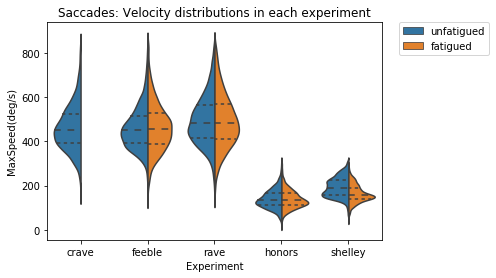

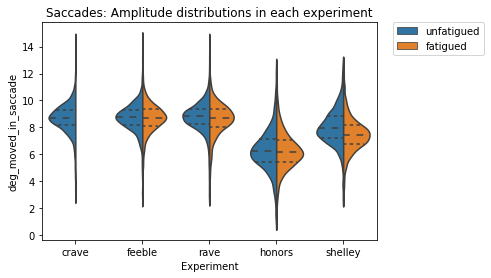

In [73]:
# figure showing max speed vs 'fatigue status' by experiment

max_velocity_status = saccades_an[['status', 'MaxSpeed(deg/s)', 'Experiment']]
ax = sns.violinplot(x='Experiment', y='MaxSpeed(deg/s)', data=max_velocity_status, 
                    hue='status', split=True,  scale='count', inner='quartile')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Saccades: Velocity distributions in each experiment')
plt.show()

# figure showing amplitude vs 'fatigue status' by experiment

amplitude_status = saccades_an[['status', 'deg_moved_in_saccade', 'Experiment']]
ax = sns.violinplot(x='Experiment', y='deg_moved_in_saccade', 
                    data=amplitude_status, hue='status', 
                    split=True,  scale='count', inner='quartile')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Saccades: Amplitude distributions in each experiment')
plt.show()

In [74]:
# add a classifier for each participant that signifies whether or not the
# participant exhibited slower eye movement velocity after exercise with 
# different interventions

# First step is to group the saccade dataset by participant, intervention and 
# timepoint. Next means need to be calculated, followed by the generation of a 
# bootstrap 90% CI. Once this has been done for each participant at each 
# timepoint, I can then use the bounds of the CI to decide if the participant 
# displayed a significant decrease in eye movement speed pre to post 
# intervention with exercise.

# define functions for bootstrapping methods

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))


def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

# create participant summary based on groups
def percentile(n):
    """percentile function to use in pandas.agg to add percentiles to grouped columns"""
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

# Bootstrap method to find confidence intervals for saccade velocity
# at each timepoint. Using these confidence intervals, I can classify whether
# pre to post the participants EM's slowed down at the 'post' timepoint by 
# comparing the the upper and lower bounds of the CI for the mean speed post 
# relative to the CI for the mean speed pre. There is a third possibility too 
# - that the eye movement increased in speed, but to begin with I am just going
# to ask "did eye movements slow down pre to post?" (1 = yes, 0 = no.)
    
# bootstrap function
    
def saccade_bs(grouped_data, saccade_type='saccade'):
    
    bs_results = pd.DataFrame(columns=['participant_num', 'intervention', 
                                       'saccade_type','EM_change', 'pre_mean',
                                       'pre_lower_bound', 'pre_upper_bound',
                                       'post_mean', 'post_lower_bound', 
                                       'post_upper_bound', 'EM_difference'])
    for name, group in grouped_data:
        # isolate timepoints within the group
        pre = group[group['timepoint'] == 'a']
        post = group[group['timepoint'] == 'b']
        
        # isolate pre and post data within groups
        pre_variable = pre['MaxSpeed(deg/s)']
        post_variable = post['MaxSpeed(deg/s)']
        
        # Compute 10,000 bootstrap replicates from pre and post data
        bs_replicates_pre = draw_bs_reps(pre_variable, np.mean, size=10000)
        bs_replicates_post = draw_bs_reps(post_variable, np.mean, size=10000)
        
        # Compute mean and difference of the bs_replicates
        pre_mean = np.mean(bs_replicates_pre)
        post_mean = np.mean(bs_replicates_post)
        difference = diff_of_means(bs_replicates_post, bs_replicates_pre)
        
        # Compute  95% CI of the mean for pre and post
        pre_lower_bound, pre_upper_bound = np.percentile(bs_replicates_pre,[5, 95])
        post_lower_bound, post_upper_bound = np.percentile(bs_replicates_post,[5, 95])
        
        # did eye movements slow, get faster or not change pre to post?
        # boolean argument for slower EMs post
        if post_upper_bound <= pre_lower_bound:
            bs_results.loc[str(name[0]) + '_' + str(name[1]) + 
                           '_' + saccade_type] = [name[0], name[1], 
                                                 saccade_type, 1,
                                                 pre_mean,
                                                 pre_lower_bound,
                                                 pre_upper_bound,
                                                 post_mean,
                                                 post_lower_bound,
                                                 post_upper_bound,
                                                 difference]
            # no change in EMs
        else:
            bs_results.loc[str(name[0]) + '_' + str(name[1]) + 
                           '_'+ saccade_type] = [name[0], name[1], 
                                                saccade_type, 0,
                                                pre_mean,
                                                pre_lower_bound,
                                                pre_upper_bound,
                                                post_mean,
                                                post_lower_bound,
                                                post_upper_bound,
                                                difference]
    return bs_results

# group the data to feed into the bootstrap
saccades_bootstrap = saccades_an.groupby(['participant_num', 'intervention'])

# create bootstrap confidence intervals and classify

bs_saccades = saccade_bs(saccades_bootstrap)

# Build a dataframe with all the variables needed in the model
# Variables:
# Outcome variable => EM_change after exercise with placebo: 1=yes, 0=no
# Sex: male / female
# VO2max: continuous variable
# age: continuous variable
# BMI: continuous variable

characteristics_df = characteristics_df.reset_index().drop_duplicates()
# convert power output to total output (kj = watts * seconds / 1000)
characteristics_df['total_output_kj'] = (characteristics_df['Watts']*(180 * 60))/1000



saccades_model = characteristics_df.merge(bs_saccades, 
                                          left_on=['participant_num'],
                                          right_on=['participant_num'])
exercise_info = saccades_an[['participant_num', 'Experiment']].drop_duplicates()
saccades_model =saccades_model.merge(exercise_info, left_on=['participant_num'],
                                    right_on=['participant_num'])

# add column describing whether they received exercise or not (1=no exercise; 0=exercise)
exercise = {'crave': 1, 'feeble': 0, 'rave': 0, 'honors': 0, 'shelley': 0}
saccades_model['Unfatigued'] = saccades_model['Experiment'].map(exercise)


# calculate BMI
saccades_model['BMI'] = saccades_model['Weight(kg)'] / (np.square(
        saccades_model['Height(m)']))

# convert sex to 0 or 1
sex = {'Male': 0, 'Female': 1}
saccades_model['Sex'] = saccades_model['Sex'].map(sex)

# categorize fitness levels given aerobic capacity, age and sex (taken from ACSM guidelines)
def fitness_category(data):
    if ((data['VO2max(ml/kg/min)'] >= 66.3 and data['Age'] >= 18 and data['Age'] <= 29 and data['Sex'] == 0) or 
    (data['VO2max(ml/kg/min)'] >= 59.8 and data['Age'] >= 30 and data['Age'] <= 39 and data['Sex'] == 0) or
    (data['VO2max(ml/kg/min)'] >= 55.6 and data['Age'] >= 40 and data['Age'] <= 49 and data['Sex'] == 0) or
    (data['VO2max(ml/kg/min)'] >= 56.0 and data['Age'] >= 18 and data['Age'] <= 29 and data['Sex'] == 1) or
    (data['VO2max(ml/kg/min)'] >= 45.8 and data['Age'] >= 30 and data['Age'] <= 39 and data['Sex'] == 1) or
    (data['VO2max(ml/kg/min)'] >= 41.7 and data['Age'] >= 40 and data['Age'] <= 49 and data['Sex'] == 1)):
        return 3 #'superior'
    elif ((57.1 < data['VO2max(ml/kg/min)'] < 66.2 and data['Age'] >= 18 and data['Age'] <= 29 and data['Sex'] == 0) or 
    (51.6 < data['VO2max(ml/kg/min)'] < 59.7 and data['Age'] >= 30 and data['Age'] <= 39 and data['Sex'] == 0) or
    (46.7 < data['VO2max(ml/kg/min)'] < 55.5 and data['Age'] >= 40 and data['Age'] <= 49 and data['Sex'] == 0) or
    (46.5 < data['VO2max(ml/kg/min)'] < 55.9 and data['Age'] >= 18 and data['Age'] <= 29 and data['Sex'] == 1) or
    (37.5 < data['VO2max(ml/kg/min)'] < 45.6 and data['Age'] >= 30 and data['Age'] <= 39 and data['Sex'] == 1) or
    (34.0 < data['VO2max(ml/kg/min)'] < 41.6 and data['Age'] >= 40 and data['Age'] <= 49 and data['Sex'] == 1)):
        return 2 #'excellent'
    elif ((50.2 < data['VO2max(ml/kg/min)'] < 57 and data['Age'] >= 18 and data['Age'] <= 29 and data['Sex'] == 0) or 
    (45.2 < data['VO2max(ml/kg/min)'] < 51.1 and data['Age'] >= 30 and data['Age'] <= 39 and data['Sex'] == 0) or
    (40.3 < data['VO2max(ml/kg/min)'] < 46.6 and data['Age'] >= 40 and data['Age'] <= 49 and data['Sex'] == 0) or
    (40.6 < data['VO2max(ml/kg/min)'] < 46.4 and data['Age'] >= 18 and data['Age'] <= 29 and data['Sex'] == 1) or
    (32.3 < data['VO2max(ml/kg/min)'] < 37.4 and data['Age'] >= 30 and data['Age'] <= 39 and data['Sex'] == 1) or
    (28.7 < data['VO2max(ml/kg/min)'] < 39.9 and data['Age'] >= 40 and data['Age'] <= 49 and data['Sex'] == 1)):
        return 1 #'good'
    elif ((44.9 < data['VO2max(ml/kg/min)'] < 50.1 and data['Age'] >= 18 and data['Age'] <= 29 and data['Sex'] == 0) or 
    (39.6 < data['VO2max(ml/kg/min)'] < 45.1 and data['Age'] >= 30 and data['Age'] <= 39 and data['Sex'] == 0) or
    (35.7 < data['VO2max(ml/kg/min)'] < 40.2 and data['Age'] >= 40 and data['Age'] <= 49 and data['Sex'] == 0) or
    (34.6 < data['VO2max(ml/kg/min)'] < 40.5 and data['Age'] >= 18 and data['Age'] <= 29 and data['Sex'] == 1) or
    (28.2 < data['VO2max(ml/kg/min)'] < 32.1 and data['Age'] >= 30 and data['Age'] <= 39 and data['Sex'] == 1) or
    (24.9 < data['VO2max(ml/kg/min)'] < 28.6 and data['Age'] >= 40 and data['Age'] <= 49 and data['Sex'] == 1)):
        return 0 #'fair'

saccades_model['fitness_category'] = saccades_model.apply(fitness_category, axis=1)

saccades_model.to_csv(directory + 'saccades_model_90CI.csv')

In [75]:
saccades_model.head()

,participant_num,Age,Sex,Weight(kg),Watts,VO2max(ml/kg/min),Height(m),total_output_kj,intervention,saccade_type,EM_change,pre_mean,pre_lower_bound,pre_upper_bound,post_mean,post_lower_bound,post_upper_bound,EM_difference,Experiment,Unfatigued,BMI,fitness_category
0,26,24,1,66.50,136,52.00,1.69,1468.80,Carbohydrate,saccade,0,540.72,526.08,555.53,540.23,522.35,558.60,-0.49,rave,0,23.39,2
1,26,24,1,66.50,136,52.00,1.69,1468.80,Methylphenidate,saccade,0,518.98,501.78,536.87,554.66,539.61,569.91,35.69,rave,0,23.39,2
2,26,24,1,66.50,136,52.00,1.69,1468.80,Reboxetine,saccade,0,533.76,516.86,550.67,574.05,554.89,593.23,40.29,rave,0,23.39,2
3,29,20,0,100.00,181,54.00,1.97,1954.80,Carbohydrate,saccade,1,481.72,474.70,488.94,445.74,437.18,454.58,-35.98,rave,0,25.82,1
4,29,20,0,100.00,181,54.00,1.97,1954.80,Methylphenidate,saccade,0,479.41,471.38,487.41,514.00,505.55,522.63,34.59,rave,0,25.82,1


#### Missing Values check

In [77]:
saccades_model.isnull().sum()

participant_num      0
Age                  0
Sex                  0
Weight(kg)           0
Watts                0
VO2max(ml/kg/min)    0
Height(m)            0
total_output_kj      0
intervention         0
saccade_type         0
EM_change            0
pre_mean             0
pre_lower_bound      0
pre_upper_bound      0
post_mean            0
post_lower_bound     0
post_upper_bound     0
EM_difference        0
Experiment           0
Unfatigued           0
BMI                  0
fitness_category     0
dtype: int64

# 3. Data exploration

In [78]:
#defining a function to plot each feature against the target variable to see if there are any obvious
# trends in the data.
# Since the data is categorical many data points would overlap in a traditional scatter plot and 
# so I am using a jitter plot, which basically spreads the points apart so they are easier to see. 
def plot_features(col_list, title):
    plt.figure(figsize=(10,14));
    i = 0
    for col in col_list:
        i += 1
        plt.subplot(5,2,i)
        sns.stripplot(saccades_model[col],saccades_model['EM_change'], jitter=True)
        plt.title(title % (col))
        plt.xticks(rotation=90)
        plt.tight_layout()

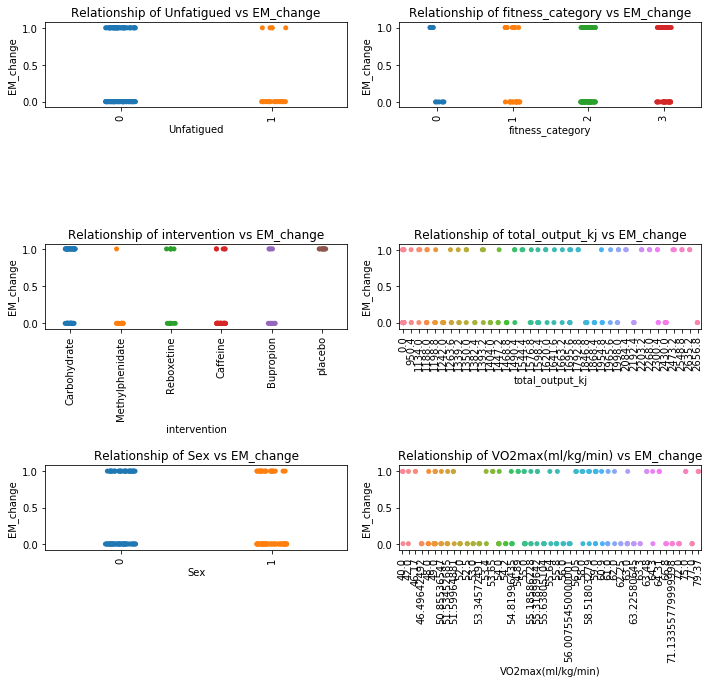

In [80]:
cols = ['Unfatigued', 'fitness_category', 'intervention', 'total_output_kj', 'Sex', 'VO2max(ml/kg/min)']
plot_features(cols, "Relationship of %s vs EM_change")
# There are some obvious trends here, ones that you would expect given the conditions that these data
# were collected under and the prior hypotheses that were made - for example, there are more instances
# of eye movement velocity change when the participants exercise compared to when they are unfatigued.
# The intervention also seems to affect EM_change. There are more instances of EM_change in the 
# placebo and Carbohydrate interventions compared to the others (which are CNS stimulants).
# In the case where participants received no energy throughout exercise ('placebo') they all 
# exhibited EM_change.
#There doesn't seem to be a relationship with fitness level / VO2max, total work performed or 
# Sex.

In [109]:
# need to convert intervention to number for model input
# categorize interventions
def intervention_category(data):
    if data['intervention'] == 'placebo':
        return 0
    elif data['intervention'] == 'Carbohydrate':
        return 1
    elif data['intervention'] == 'Caffeine':
        return 2
    elif data['intervention'] == 'Bupropion':
        return 3
    elif data['intervention'] == 'Methylphenidate':
        return 4
    elif data['intervention'] == 'Reboxetine':
        return 5
    
saccades_model['intervention_category'] = saccades_model.apply(intervention_category, axis=1)
saccades_model['fitness_category'].unique()

array([1, 4, 5, 2, 3, 0])

In [115]:
saccades_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 137
Data columns (total 23 columns):
participant_num          138 non-null object
Age                      138 non-null int64
Sex                      138 non-null int64
Weight(kg)               138 non-null float64
Watts                    138 non-null int64
VO2max(ml/kg/min)        138 non-null float64
Height(m)                138 non-null float64
total_output_kj          138 non-null float64
intervention             138 non-null object
saccade_type             138 non-null object
EM_change                138 non-null object
pre_mean                 138 non-null float64
pre_lower_bound          138 non-null float64
pre_upper_bound          138 non-null float64
post_mean                138 non-null float64
post_lower_bound         138 non-null float64
post_upper_bound         138 non-null float64
EM_difference            138 non-null float64
Experiment               138 non-null object
Unfatigued               138 non

In [132]:
# redefine cols
cols = ['fitness_category', 'intervention_category', 'total_output_kj', 'Sex', 'VO2max(ml/kg/min)']

# 4. Explore models and model selection

In [211]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split 
from sklearn.cross_validation import cross_val_score 
from sklearn.metrics import (auc, roc_curve, roc_auc_score,
                             accuracy_score, precision_score,
                             recall_score, f1_score, )
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.stats.stats import pearsonr
import operator
import itertools

In [252]:
# The classes are unbalanced so I am rebalancing them in the respective classifiers for the logistic
# regression
logistic = LogisticRegression(class_weight='balanced')
knn = KNeighborsClassifier()

In [253]:
# Splitting the data into training and testing data
X = saccades_model[cols]
y = saccades_model['EM_change']
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [254]:
# Defining a function to calculate metrics on the various classifiers for easy comparison
def classifier_metrics_accuracy(clf):
    clf.fit(X_train, y_train)
 
    print ('%30s: %s' % ('Default score (accuracy)', clf.score(X_train, y_train)))
    print ('%30s: %s' % ('Cross val score', cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()))
    print ('%30s: %s' % ('AUC', (cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean())))
    print ('%30s: %s' % ('Precision', (cross_val_score(clf, X_train, y_train, cv=5, scoring='precision_weighted').mean())))
    print ('%30s: %s' % ('Recall', (cross_val_score(clf, X_train, y_train, cv=5, scoring='recall_weighted').mean())))
    print ('%30s: %s' % ('F1', (cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_weighted').mean())))
    print ('\n')

In [255]:
for clf in [logistic, knn]: 
    print ('Metrics for %s' % clf)
    print ('=' * 50)
    classifier_metrics_accuracy(clf)

Metrics for LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
      Default score (accuracy): 0.6727272727272727
               Cross val score: 0.644927536231884
                           AUC: 0.7057993197278911
                     Precision: 0.7158262550653854
                        Recall: 0.644927536231884
                            F1: 0.6472720370350842


Metrics for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
      Default score (accuracy): 0.7181818181818181
               Cross val score: 0.5985319028797289
                           AUC: 0.5888095238095238
                     Precision: 0.5290035229125282
                        Recall:

## Although the accuracy score is higher with K-nearest neighbors, the cross validation and AUC scores are better using a logistic regression.
This means that the logistic regression is generalizing better and optimizing true positives while minimizing false positives to a greater capacity than the KNN model. Because of this, I am going to proceed with the logistic regression.

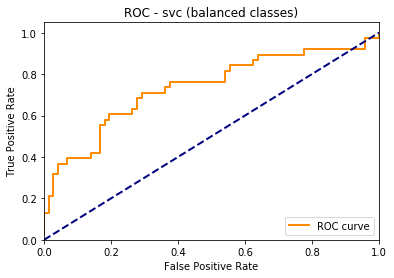

In [256]:
#visualizing the ROC curve for the logistic regression

y_score = logistic.fit(X_train, y_train).decision_function(X_train)

# Compute ROC curve and ROC area for each class

fpr, tpr, _ = roc_curve(y_train, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - svc (balanced classes)')
plt.legend(loc="lower right")
plt.show()

# 5. Assessing model assumptions, hyperparameter optimization and further feature engineering

This model assumes independence of features so I'll look to see if the features are correlated with one another. On the plus side, the data does not need to be linearly correlated or normally distributed

In [257]:
# Checking correlations between features - r^2 threshold of .75 or above is considered 
# strongly correlated. 
correlations = {}
for col_a, col_b in itertools.combinations(cols, 2):
    correlations[col_a + '__' + col_b] = pearsonr(saccades_model.loc[:, col_a], 
                                                  saccades_model.loc[:, col_b])

result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ['PCC', 'p-value']

print(result.sort_index())

                                           PCC  p-value
Sex__VO2max(ml/kg/min)                   -0.35     0.00
fitness_category__Sex                     0.27     0.00
fitness_category__VO2max(ml/kg/min)       0.70     0.00
fitness_category__intervention_category  -0.02     0.82
fitness_category__total_output_kj         0.16     0.07
intervention_category__Sex                0.18     0.03
intervention_category__VO2max(ml/kg/min) -0.08     0.34
intervention_category__total_output_kj   -0.00     0.99
total_output_kj__Sex                     -0.40     0.00
total_output_kj__VO2max(ml/kg/min)        0.37     0.00


No strongly correlated features to worry about

#### Scaling the features may also improve the model because total_output_kj and VO2max goes quite high (up to ~2000 and ~70, respectively) while the other features are between 0-1 or 0-5. I'm going to use a min-max scaler because all of my data is non-negative.

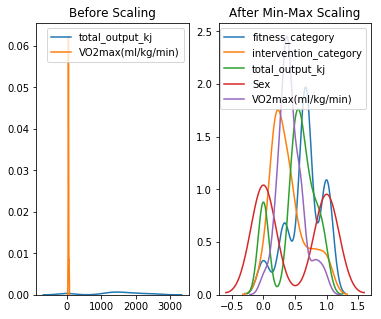

In [258]:
scaler = preprocessing.MinMaxScaler()
scaled_saccades = scaler.fit_transform(saccades_model[cols])
scaled_saccades = pd.DataFrame(scaled_saccades, columns=list(saccades_model[cols]))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))
ax1.set_title('Before Scaling')
#sns.kdeplot(saccades_model['fitness_category'], ax=ax1)
#sns.kdeplot(saccades_model['intervention_category'], ax=ax1)
sns.kdeplot(saccades_model['total_output_kj'], ax=ax1)
#sns.kdeplot(saccades_model['Sex'], ax=ax1)
sns.kdeplot(saccades_model['VO2max(ml/kg/min)'], ax=ax1)
ax2.set_title('After Min-Max Scaling')
sns.kdeplot(scaled_saccades['fitness_category'], ax=ax2)
sns.kdeplot(scaled_saccades['intervention_category'], ax=ax2)
sns.kdeplot(scaled_saccades['total_output_kj'], ax=ax2)
sns.kdeplot(scaled_saccades['Sex'], ax=ax2)
sns.kdeplot(scaled_saccades['VO2max(ml/kg/min)'], ax=ax2)
plt.show()

You can see the scaling made quite a difference visually. I only showed the total output and VO2max data on the 'Before Scaling' graph because they were the ones with the very large range. The other features were barely perceptible on the graph because they had such small ranges. The 'After Min-Max Scaling' graph shows all features falling within the same range.

In [260]:
# recreating the dataset to be split into test and training
scaled_saccades['EM_change'] = saccades_model['EM_change']

In [261]:
# Re-splitting the scaled data into training and testing data

X = scaled_saccades[cols]
y = scaled_saccades['EM_change']
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [262]:
# tuning the model parameters
PARAMETERS = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag']}
SCORING = 'accuracy'

from sklearn import grid_search

#Grid Search
model = LogisticRegression(class_weight='balanced')
clf = grid_search.GridSearchCV(model, PARAMETERS, scoring=SCORING, verbose=True)
clf.fit(X_train, y_train)

#After completion, show the final best results and scores
print (clf.best_estimator_)
print (clf.best_score_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.6454545454545455


[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.4s finished


# 6. Evaluate model

In [263]:
# Using the optimized model
logistic_model = LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [264]:
clf = logistic_model.fit(X_train, y_train)
clf.coef_ #Looking at the most important features

array([[ 0.03874465, -0.33022708,  0.27143783, -0.10524263, -0.01612008]])

In [265]:
X_train.columns

Index(['fitness_category', 'intervention_category', 'total_output_kj', 'Sex',
       'VO2max(ml/kg/min)'],
      dtype='object')

In [266]:
important_features = zip(X_train.columns, clf.coef_.ravel())
sorted(important_features, key=operator.itemgetter(1), reverse=True)

[('total_output_kj', 0.27143782941680966),
 ('fitness_category', 0.0387446499613517),
 ('VO2max(ml/kg/min)', -0.016120075184892495),
 ('Sex', -0.10524262587926048),
 ('intervention_category', -0.33022708401286605)]

In [267]:
y_eval = clf.predict(X_test)

In [268]:
print ("Overall model accuracy is %s" % (accuracy_score(y_test, y_eval)))

Overall model accuracy is 0.6428571428571429


In [269]:
print (classification_report(y_test, y_eval, labels=[0, 1]))

             precision    recall  f1-score   support

          0       0.64      0.88      0.74        16
          1       0.67      0.33      0.44        12

avg / total       0.65      0.64      0.61        28



In [271]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix. """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=22)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

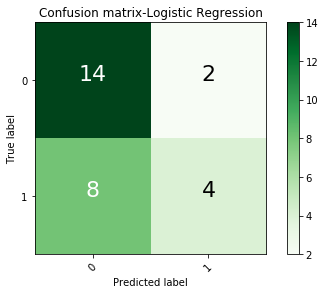

In [272]:
conf_logistic = confusion_matrix(y_test, y_eval)
plot_confusion_matrix(conf_logistic, classes=[0, 1], title = 'Confusion matrix-Logistic Regression')
plt.show()

# 7. Insights and conclusions

Here I used a logistic regression to predict whether a person displayed brain fatigue in an experiment given the experiment parameters (intervention, exercise) and participant characteristics (fitness, sex). I removed missing values and highly correlated features from the data set before splitting the data into test and training data. Since the two classes were unbalanced to begin with, I rebalanced classes using the built-in functionality in sklearn. I optimized the hyperparameters of the logistic regression by trying different C parameters and solvers. The model generalized well as evidenced by similar accuracy scores in the training and testing data, although its level of accuracy was not that great overall. 

Finally, I generated a confusion matrix which showed that 10 samples were misclassified - 8 false negatives and 1 false positives. This model could be greatly improved with the addition of more data, from a set of paticipants with a wider range of ages and fitness levels. Important features for this model include Intervention, total physical work performed and Sex.